In [1]:
#导入必要的库
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.optimizers import Nadam

# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
# 设置随机种子
np.random.seed(1234)

# tensorflow V2.x
# For Tensorflow 2.0 tf.random.set_random_seed(seed) changed to tf.random.set_seed(seed).
tf.random.set_seed(1234)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import csv
import os
directory='/content/drive/My Drive/taidi/'
filename='month_sum.csv'
filepath=os.path.join(directory,filename)

In [5]:
# 读取数据
# df = pd.read_csv('./全部数据/order_train1.csv',parse_dates=["order_date"],index_col=[0])   # 把日期变为索引
# df = pd.read_csv('./全部数据/order_train1.csv')   
df = pd.read_csv(filepath)  

first_col = df.pop('ord_qty')
df.insert(1, 'ord_qty', first_col)  #把订单量变为第一列

display(df)  
df.info()

,order_date,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,item_price,brand_qty_median,brand_qty_average,rmean_1_1
0,2015/9/1,3091,20007,101,305,412,2015,9,99.384615,28,84.39,0
1,2015/9/1,308,20008,101,303,401,2015,9,657.000000,22,56.08,0
2,2015/9/1,260,20009,101,306,407,2015,9,672.000000,36,112.20,0
3,2015/9/1,19,20019,101,302,408,2015,9,1195.000000,24,66.75,0
4,2015/9/1,265,20020,101,305,412,2015,9,1909.428571,28,84.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56155,2018/12/1,7224,22066,105,307,403,2018,12,330.666667,41,112.68,10535
56156,2018/12/1,488,22072,105,305,412,2018,12,409.600000,28,84.39,1842
56157,2018/12/1,16,22080,105,306,407,2018,12,504.000000,36,112.20,8
56158,2018/12/1,7,22081,105,303,401,2018,12,2569.000000,22,56.08,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56160 entries, 0 to 56159
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_date         56160 non-null  object 
 1   ord_qty            56160 non-null  int64  
 2   item_code          56160 non-null  int64  
 3   sales_region_code  56160 non-null  int64  
 4   first_cate_code    56160 non-null  int64  
 5   second_cate_code   56160 non-null  int64  
 6   year               56160 non-null  int64  
 7   month              56160 non-null  int64  
 8   item_price         56160 non-null  float64
 9   brand_qty_median   56160 non-null  int64  
 10  brand_qty_average  56160 non-null  float64
 11  rmean_1_1          56160 non-null  int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 5.1+ MB


In [12]:
testset_start = df[(df.year==2018)&(df.month==9)].index.tolist()[0]
testset_end = df[(df.year==2018)&(df.month==11)].index.tolist()[-1]
print(testset_start, testset_end)

48594 54363


In [6]:
#设置LSTM的时间窗等参数
window = 30  # 30 3 240
lstm_units = 100  # 100 200
dropout = 0.01  
epoch=50  # 最大epoch, 会早停
batch_size = 128  # 128 480
activation='tanh'

In [7]:
y = df['ord_qty']

# 数据标准化，选用min-max方法，以提高神经网络性能
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))  # scale of the output and input in the range 0–1 to match the scale of the layer of LSTM
y=scaler.fit_transform(np.array(y).reshape(-1,1)) # reshape:convert the univariate 1D array into 2D  # n行1列
print(y.shape)


(56160, 1)


In [13]:
# 拆分训练/验证集
# train_size = int(len(y) * 0.9)
# # test_size = len(df) - train_size
# df_for_training=y[0:train_size,:]
# df_for_testing=y[train_size:len(y),:1]

df_for_training=y[0:testset_start-1,:]
df_for_testing=y[testset_start:testset_end,:1]

# input_size=len(df.iloc[1,:])  # 特征数量
input_size = 1

print(df_for_training.shape)
print(df_for_testing.shape)

(48593, 1)
(5769, 1)


In [14]:
# import numpy as np
# import pandas as pd
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # 数据标准化
# scaler = MinMaxScaler(feature_range=(0,1))
# df_for_training_scaled = scaler.fit_transform(df_for_training)
# df_for_testing_scaled=scaler.transform(df_for_testing)

In [15]:
# 分X,Y
def createXY(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+window), 0]   
		dataX.append(a)
		dataY.append(dataset[i + window, 0]) #第一列为订单量
	return np.array(dataX), np.array(dataY)

time_step = window
trainX,trainY=createXY(df_for_training,window)
testX,testY=createXY(df_for_testing,window)

# reshape X
trainX = trainX.reshape(trainX.shape[0],trainX.shape[1],1)
testX = testX.reshape(testX.shape[0],testX.shape[1],1)

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
# print(trainX.shape[2])

(48562, 30, 1)
(48562,)
(5738, 30, 1)
(5738,)


In [18]:
#建立LSTM模型 训练

# 优化器
my_adam = Adam(learning_rate=0.001)
my_nadam = Nadam(learning_rate = 0.001)

inputs=Input(shape=(window, input_size))
# model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
# model=MaxPooling1D(pool_size = window)(model)#池化层
# model=Dropout(dropout)(model)#droupout层
# 第一层LSTM，12是单元个数超参数，多层LSTM前面几层必须return_sequences=True，输入window个时间步，input_size个特征
model=Bidirectional(LSTM(lstm_units, activation=activation,return_sequences=True), name='bilstm')(inputs)#双向LSTM层
model=Dropout(dropout)(model)#droupout层
# 最后一层LSTM,return_sequences=False
model=Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=False),name='bilstm2')(model)
model=Dropout(dropout)(model)#droupout层
# attention=Dense(lstm_units, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
# model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer=my_nadam)


# model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
# model.compile(loss='mse',optimizer=my_nadam)
model.summary()#展示模型结构

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 bilstm (Bidirectional)      (None, 30, 200)           81600     
                                                                 
 dropout (Dropout)           (None, 30, 200)           0         
                                                                 
 bilstm2 (Bidirectional)     (None, 200)               240800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 322,601
Trainable params: 322,601
Non-trainable

In [19]:
# use early stop to avoid over-fiting  早停法防止过拟合,若loss不减小，训练停止
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=15, 
        verbose=1, mode='auto', restore_best_weights=True)

# 模型训练
history=model.fit(trainX, trainY, epochs = epoch, batch_size = batch_size, shuffle=False,callbacks=[monitor], validation_data=(testX, testY)) #训练模型epoch次

Epoch 1/50
380/380 [==============================] - 19s 19ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 2/50
380/380 [==============================] - 5s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/50
380/380 [==============================] - 6s 16ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/50
380/380 [==============================] - 5s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/50
380/380 [==============================] - 5s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/50
380/380 [==============================] - 8s 20ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/50
380/380 [==============================] - 5s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/50
380/380 [==============================] - 6s 15ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/50
380/380 [==============================] - 5s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
380/380 [==============================] - 5s 13ms/step - loss: 0.0015 - val_l

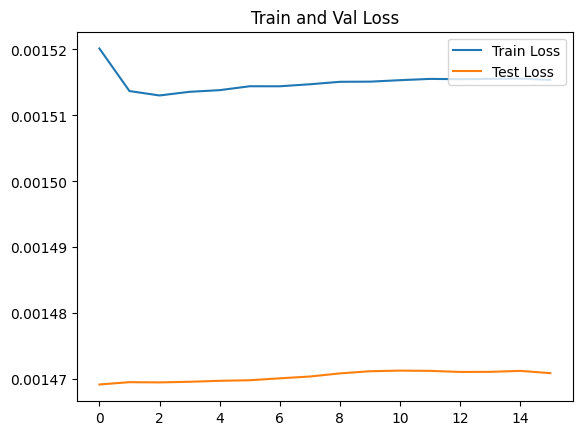

In [20]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
# epochs_range = range(epoch)
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

In [21]:
# # create the list of difference between prediction and test data
# predictions = model.predict(testX)
# len(predictions)

# # Showing the predicted vs. actual values
# fig, axs = plt.subplots()
# fig.set_figheight(8)
# fig.set_figwidth(15)

# axs.plot(testY,color='blue', label='Actual',linestyle='--',linewidth=1)
# axs.plot(predictions,color='red', label='Predicted',linewidth=1)
# # axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
# plt.title('Prediction  with standardize data')
# plt.xlabel('Time Steps')
# plt.ylabel('Order quantity (Standardized Data)')
# plt.legend(loc='upper left')
# plt.show()

# # plot_1(history1, 'Training / Validation Losses from History')

In [22]:
# # score=model.evaluate(testX,testY,verbose=0)
# # print('Test mse with Standardized Data:')
# # print(score)
# # # print('Test Loss:',score[0])
# # # print('Test mae:',score[1])

# # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
# print('----------with standarded data----------')
# print("mean_absolute_error:", mean_absolute_error(testY, predictions))
# print("mean_squared_error:", mean_squared_error(testY, predictions))
# print("rmse:", sqrt(mean_squared_error(testY, predictions)))
# print("r2 score:", r2_score(testY, predictions))


180/180 [==============================] - 2s 5ms/step
(5738, 1)


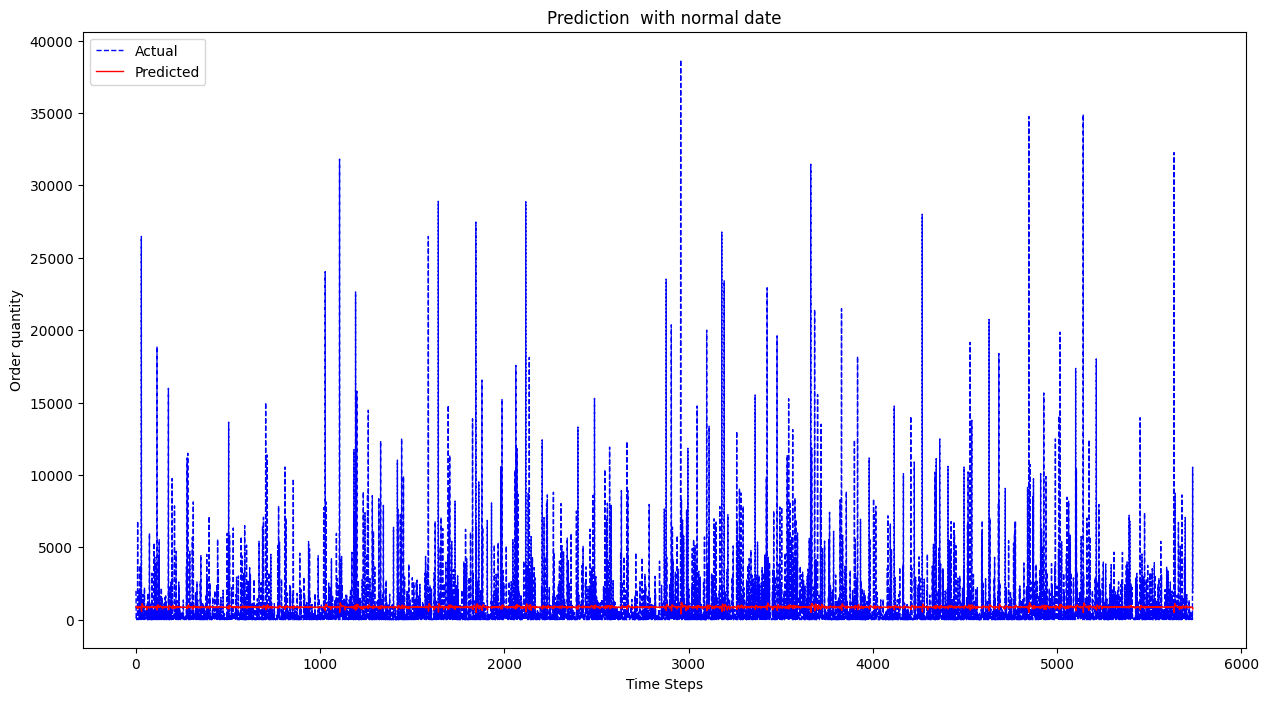

In [23]:
# 还原模型预测

# create the list of difference between prediction and test data
predictions = model.predict(testX)
print(predictions.shape)

# 反归一化
prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]


# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(testY_inv,color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(predictions_inv,color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [24]:
# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
print('------------验证集-------------')
print("mae:", mean_absolute_error(testY_inv, predictions_inv))
print("mape:", mean_absolute_percentage_error(testY_inv, predictions_inv))
print("mse:", mean_squared_error(testY_inv, predictions_inv))
print("rmse:", sqrt(mean_squared_error(testY_inv, predictions_inv)))
print("r2:", r2_score(testY_inv, predictions_inv))

------------验证集-------------
mae: 1213.4246749319486
mape: 38.21214222796795
mse: 6877186.311240513
rmse: 2622.439000480376
r2: 0.00025885838182337917
